# NFL Win Probability Charts

In [2]:
# Data processing
import pandas as pd
import numpy as np
import csaps
from scipy.interpolate import interp1d

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from celluloid import Camera

# Additional functions and data
import requests
import time
import team_colors as colors
import team_names as names

# Seaborn style settings
sns.set(style="whitegrid", 
        palette="pastel", 
        font='IBM Plex Mono', 
        font_scale = 1.1,
        rc= {'grid.color': '.95', 
             'xtick.color': 'dimgray', 
             'ytick.color': 'dimgray',
             'axes.labelcolor': '.3',
            })

### If you have font issues, try these, otherwise ignore

In [2]:
# In case matplotlib doesn't find your font!

import matplotlib.font_manager as font_manager 

font_manager._rebuild()

In [ ]:
# In case matplotlib misinterprets the font weights
# This fix doesn't always work, though.

from fontTools.ttLib import TTFont, TTCollection
from matplotlib.font_manager import fontManager
from pathlib import Path

for font in fontManager.ttflist:
    path = Path(font.fname)
    
    if (path.suffix == '.ttc'):
        font_collection = TTCollection(path).fonts
    else:
        font_collection = [TTFont(path)]
    
    for font_obj in font_collection:
        try:
            font.weight = font_obj['OS/2'].usWeightClass
        except:
            pass

fontManager._findfont_cached.cache_clear()

## Data
Add the path to your nflscrapR data file here!

In [3]:
df = pd.read_csv("data/reg_pbp_2019.csv", low_memory=False)

In [4]:
#Adding week numbers to main dataframe

try:
    response_reg = requests.get('http://www.nfl.com/feeds-rs/schedules/2019.json').json()
except requests.exceptions.RequestException as e:
    print(e)

schedules = pd.DataFrame.from_dict(response_reg['gameSchedules'])
schedules = schedules.loc[schedules['seasonType'] == 'REG', ['gameId', 'week']]

schedules = schedules.rename(columns={'gameId' : 'game_id'})

df = df.merge(schedules, how='left', on=['game_id'])

## Helper functions

In [5]:
# Function to fetch game ID for a single game

def get_game(week, team):
    
    return df.loc[((df['home_team'] == team) | (df['away_team'] == team)) & (df['week'] == week), 'game_id'].unique()[0]


# Function to getting all the game IDs for a team

def get_schedule(df, team=None):
    
    if team:
    
        schedule = (
            df[(df['home_team'] == team) | (df['away_team'] == team)]
                .groupby(['game_date', 'game_id', 'away_team', 'home_team', 'week'])
                [['total_away_score','total_home_score']]
                .max()
                .reset_index()
                .sort_values('game_date')
                )
    else:
        schedule = (df
                    .groupby(['game_date', 'game_id', 'away_team', 'home_team', 'week'])[['total_away_score','total_home_score']]
                    .max()
                    .reset_index()
                    .sort_values('game_date'))

    return schedule

In [6]:
def interpolate(x, y, frames, smooth=False, smoothing=None, animation=False):
    
    if smooth:
        
        sp = csaps.UnivariateCubicSmoothingSpline(x, y, smooth=smoothing)

        xs = np.linspace(x[-1], x[0], frames)
        ys = sp(xs)

        return xs, ys

    elif animation: 
        
        f = interp1d(x, y)
        
        xnew = np.linspace(x[-1], x[0], frames)
        ynew = f(xnew)
        
        return xnew, ynew
    else:
        
        return x, y

In [7]:
# Since we're interpolating the data (adding new datapoints), we can't read the score and time remaining
# directly from the dataframe. We have to infer what the score/clock would have shown for the interpolated points.

def get_score(win_probs, team, minutes_remaining):
    
    if team == 'home':
        
        return int(win_probs.loc[win_probs['game_minutes_remaining'] >= minutes_remaining, 'total_home_score'].max())
    
    else:
        
        return int(win_probs.loc[win_probs['game_minutes_remaining'] >= minutes_remaining, 'total_away_score'].max())
    

def get_time(win_probs, minutes_remaining):
    
    quarter = int(4 - np.floor(minutes_remaining/15))
    
    seconds_remaining = np.floor(minutes_remaining * 60)

    number_of_seconds = int((seconds_remaining - ((4-quarter)*15)*60))
    time_left = time.strftime("%M:%S", time.gmtime(number_of_seconds))
    
    return quarter, time_left

## Static plots

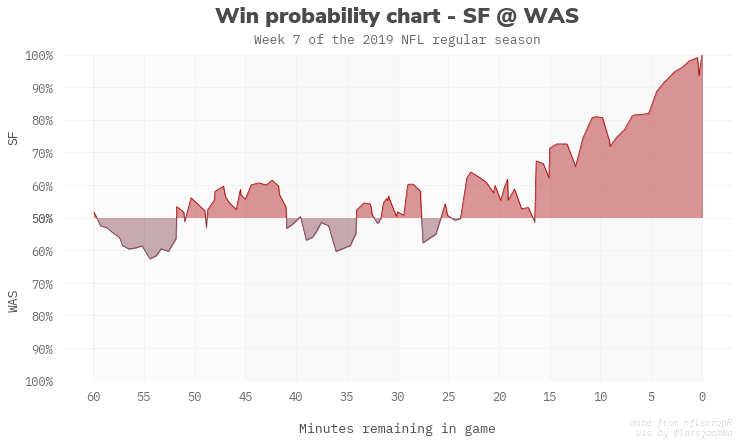

In [9]:
# ------------------ PARAMETERS ------------------ #

team = 'SF'
week = 7
game = get_game(week, team)

team_colors = colors.get_colors()
bg_alpha_1 = 0.3 #Transparency of the grey background colors separating the quarters
bg_alpha_2 = 0.65

smooth = False
smoothing = 0.98
points = 300

# ------------------ PREPARE DATA AND MATPLOTLIB FIGURE OBJECT ------------------ #

home_team, away_team, week = df[df['game_id'] == game][['home_team', 'away_team', 'week']].values[0]

win_probs = df.loc[df['game_id'] == game,['away_wp', 'home_wp', 'game_seconds_remaining', 'total_home_score', 'total_away_score', 'qtr']]
                    
# To avoid cases where we have two plays with the same time left (and two different WP values), I take the mean.
win_probs = win_probs.groupby(['game_seconds_remaining'])['home_wp', 'away_wp', 'total_home_score', 'total_away_score', 'qtr'].mean().reset_index().dropna()

win_probs['game_minutes_remaining'] = win_probs['game_seconds_remaining']/60

f, ax = plt.subplots(figsize=(12, 6))
plt.subplots_adjust(hspace = 0)

# ------------------ PLOT AWAY TEAM ------------------ #

ax_away = plt.subplot(2, 1, 1)

x=win_probs['game_minutes_remaining'].values
y=win_probs['away_wp'].values

x, y = interpolate(x, y, points, smooth, smoothing)

sns.lineplot(x=x, y=y, color=team_colors[away_team], lw=0.7, ax=ax_away)

ax_away.set_title('Win probability chart - {} @ {}\n'.format(away_team, home_team),
              fontfamily='Nunito Sans',
              fontsize=22, 
              weight=900, 
              ha='center', 
              va='bottom', 
              color='black',
              alpha=0.7,
             )

ax_away.text(x=0.5, 
             y=1.025, 
             s='Week {} of the 2019 NFL regular season'.format(week), 
             fontsize=13,
             weight=300,
             style='normal',
             color='dimgray', 
             ha='center', 
             va='bottom', 
             transform=ax.transAxes)

ax_away.fill_between(x, 
                 y, 
                 color=team_colors[away_team], 
                 alpha = 0.4,
                 edgecolor=None
                )

#backgrounds to separate quarters
ax_away.fill_between([60,45], y1=100, color='whitesmoke', alpha=bg_alpha_1, edgecolor=None, zorder=-2)
ax_away.fill_between([45,30], y1=100, color='whitesmoke', alpha=bg_alpha_2, edgecolor=None, zorder=-2)
ax_away.fill_between([30,15], y1=100, color='whitesmoke', alpha=bg_alpha_1, edgecolor=None, zorder=-2)
ax_away.fill_between([15,0], y1=100, color='whitesmoke', alpha=bg_alpha_2, edgecolor=None, zorder=-2)  

ax_away.set_ylim((0.5,1))
ax_away.set_ylabel(away_team, weight='medium')

ax_away.yaxis.set_major_formatter(FuncFormatter('{:.0%}'.format))
ax_away.xaxis.set_major_locator(plt.MaxNLocator(14))

ax_away.invert_xaxis()


# ------------------ PLOT HOME TEAM ------------------ #

ax_home = plt.subplot(2, 1, 2)

x=win_probs['game_minutes_remaining'].values
y=win_probs['home_wp'].values

x, y = interpolate(x, y, points, smooth, smoothing)

sns.lineplot(x=x, y=y, color=team_colors[home_team], lw=0.7, ax=ax_home)

ax_home.fill_between(x, 
                 y, 
                 color=team_colors[home_team], 
                 alpha = 0.4,
                 edgecolor=None
                )

#backgrounds to separate quarters
ax_home.fill_between([60,45], y1=100, color='whitesmoke', alpha=bg_alpha_1, edgecolor=None, zorder=-2)
ax_home.fill_between([45,30], y1=100, color='whitesmoke', alpha=bg_alpha_2, edgecolor=None, zorder=-2)
ax_home.fill_between([30,15], y1=100, color='whitesmoke', alpha=bg_alpha_1, edgecolor=None, zorder=-2)
ax_home.fill_between([15,0], y1=100, color='whitesmoke', alpha=bg_alpha_2, edgecolor=None, zorder=-2)  

ax_home.set_ylim((0.5,1))
ax_home.yaxis.set_major_formatter(FuncFormatter('{:.0%}'.format))
ax_home.xaxis.set_major_locator(plt.MaxNLocator(14))

ax_home.invert_xaxis()
ax_home.invert_yaxis()


ax_home.set_ylabel(home_team, weight='medium')
ax_home.set_xlabel("\nMinutes remaining in game", weight='medium')

ax_home.text(x=1, 
    y=-0.35, 
    s='data from nflscrapR\nviz by @larsjaakko', 
    fontsize=9,
    weight=300,
    style='italic',
    color='darkgray', 
    ha='right', 
    va='bottom', 
    transform=ax_home.transAxes)


sns.despine(left=True, right=True, bottom=True, top=True)

filename = str(away_team + '_at_' + home_team)

if smooth:
    plt.savefig('output/' + filename + '_smooth.png', format='png', dpi=300, bbox_inches='tight')
else:
    plt.savefig('output/' + filename + '.png', format='png', dpi=300, bbox_inches='tight')
    

## Animated!
Note: in order to make the animation smooth, I've added interpolations to get extra frames. Even if you choose `smooth=False`, the interpolation will remove some of the more minute variations in the WP curve. If you don't want any alterations of the curve, the code would need slight tweaking in order to use the exact number of frames as there are datapoints.

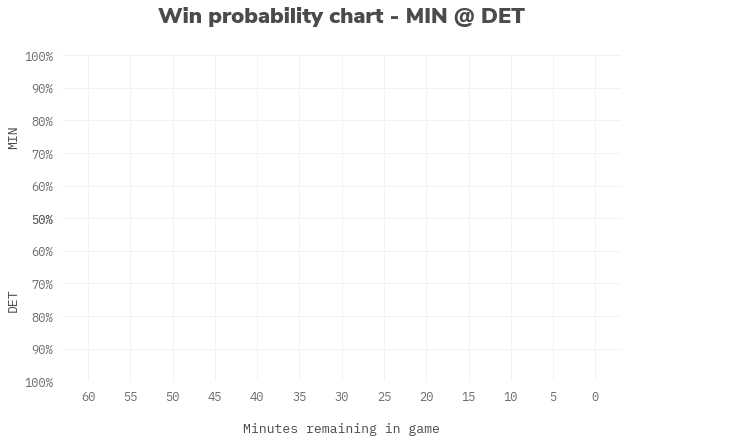

In [12]:
# ------------------ PARAMETERS ------------------ #

team = 'MIN'
week = 7
game = get_game(week, team)

team_colors = colors.get_colors()
bg_alpha_1 = 0.3 #Transparency of the grey background colors separating the quarters
bg_alpha_2 = 0.65

smooth = True
smoothing = 0.98 #Smoothing parameter for csaps, see https://github.com/espdev/csaps

frames = 500
framerate = 30

# ------------------ PREPARE DATA AND MATPLOTLIB FIGURE OBJECT ------------------ #

home_team, away_team, week = df[df['game_id'] == game][['home_team', 'away_team', 'week']].values[0]

win_probs = df.loc[df['game_id'] == game,['away_wp', 'home_wp', 'game_seconds_remaining', 'total_home_score', 'total_away_score', 'qtr']]
                    
# To avoid cases where we have two plays with the same time left (and two different WP values), I take the mean.
win_probs = win_probs.groupby(['game_seconds_remaining'])['home_wp', 'away_wp', 'total_home_score', 'total_away_score', 'qtr'].mean().reset_index().dropna()

win_probs['game_minutes_remaining'] = win_probs['game_seconds_remaining']/60

fig = plt.figure(figsize=(12, 6), constrained_layout=False)
gs = fig.add_gridspec(nrows=2, ncols=6, hspace=0, wspace=0)

ax_away = fig.add_subplot(gs[0, :-1])
ax_home = fig.add_subplot(gs[-1, :-1])
ax_score = fig.add_subplot(gs[:, -1])

camera = Camera(fig)

for i in range(frames+1):

    # ------------------ PLOT AWAY TEAM ------------------ #

    x=win_probs['game_minutes_remaining'].values
    y=win_probs['away_wp'].values

    x, y = interpolate(x, y, frames, smooth, smoothing, animation=True)

    sns.lineplot(x=x[:i], y=y[:i], color=team_colors[away_team], lw=0.7, ax=ax_away)

    ax_away.set_title('Win probability chart - {} @ {}\n'.format(away_team, home_team),
                      y=1.04,
                      fontfamily='Nunito Sans',
                      fontsize=22, 
                      weight=900, 
                      ha='center', 
                      va='bottom', 
                      color='black',
                      alpha=0.7,
                      transform=ax_away.transAxes
                     )

    ax_away.text(s='Week {} of the 2019 NFL regular season'.format(week), 
                 x=0.5,
                 y=1.07,
                 fontsize=13,
                 weight=300,
                 style='normal',
                 color='dimgray', 
                 ha='center', 
                 va='bottom',
                 transform=ax_away.transAxes
                )

    ax_away.fill_between(x[:i], 
                     y[:i], 
                     color=team_colors[away_team], 
                     alpha = 0.4,
                     edgecolor=None
                    )

    #backgrounds to separate quarters
    ax_away.fill_between([60,45], y1=100, color='whitesmoke', alpha=bg_alpha_1, edgecolor=None, zorder=-2)
    ax_away.fill_between([45,30], y1=100, color='whitesmoke', alpha=bg_alpha_2, edgecolor=None, zorder=-2)
    ax_away.fill_between([30,15], y1=100, color='whitesmoke', alpha=bg_alpha_1, edgecolor=None, zorder=-2)
    ax_away.fill_between([15,0], y1=100, color='whitesmoke', alpha=bg_alpha_2, edgecolor=None, zorder=-2)  

    ax_away.set_ylim((0.5,1))
    ax_away.set_ylabel(away_team, weight='medium')

    ax_away.yaxis.set_major_formatter(FuncFormatter('{:.0%}'.format))
    ax_away.xaxis.set_major_locator(plt.MaxNLocator(14))

    ax_away.invert_xaxis()


    # ------------------ PLOT HOME TEAM ------------------ #        

    x=win_probs['game_minutes_remaining'].values
    y=win_probs['home_wp'].values

    x, y = interpolate(x, y, frames, smooth, smoothing, animation=True)

    sns.lineplot(x=x[:i], y=y[:i], color=team_colors[home_team], lw=0.7, ax=ax_home)

    ax_home.fill_between(x[:i], 
                     y[:i], 
                     color=team_colors[home_team], 
                     alpha = 0.4,
                     edgecolor=None
                    )

    #backgrounds to separate quarters
    ax_home.fill_between([60,45], y1=100, color='whitesmoke', alpha=bg_alpha_1, edgecolor=None, zorder=-2)
    ax_home.fill_between([45,30], y1=100, color='whitesmoke', alpha=bg_alpha_2, edgecolor=None, zorder=-2)
    ax_home.fill_between([30,15], y1=100, color='whitesmoke', alpha=bg_alpha_1, edgecolor=None, zorder=-2)
    ax_home.fill_between([15,0], y1=100, color='whitesmoke', alpha=bg_alpha_2, edgecolor=None, zorder=-2)  

    ax_home.set_ylim((0.5,1))
    ax_home.yaxis.set_major_formatter(FuncFormatter('{:.0%}'.format))
    ax_home.xaxis.set_major_locator(plt.MaxNLocator(14))

    ax_home.invert_xaxis()
    ax_home.invert_yaxis()


    ax_home.set_ylabel(home_team, weight='medium')
    ax_home.set_xlabel("\nMinutes remaining in game", weight='medium')


    # ------------------ PLOT SCORE BOX ------------------ #

    ax_score.axis('off')
    
    # Quarter and time remaining
    ax_score.annotate(
        'Q{}\n{}'.format(get_time(win_probs, x[i-1])[0], get_time(win_probs, x[i-1])[1]), 
        (0.5, 0.5),
        xycoords='axes fraction', 
        va='center',
        ha='center',
        fontsize=24,
        color='darkgrey',
        weight=400
    )

    # Away score
    ax_score.annotate(
        '{}'.format(get_score(win_probs, 'away', x[i-1])), 
        (0.5, 0.725),
        fontfamily='Nunito Sans',
        xycoords='axes fraction', 
        va='center',
        ha='center',
        fontsize=42,
        color='black',
        alpha=0.7,
        weight=900,
    )

    # Away team name
    ax_score.annotate(
        '{}'.format(names.get_short_name(away_team)), 
        (0.5, 0.9),
        fontfamily='Nunito Sans',
        xycoords='axes fraction', 
        va='center',
        ha='center',
        fontsize=22,
        color=team_colors[away_team],
        weight=900,
        alpha=0.6
    )

    # Home score
    ax_score.annotate(
        '{}'.format(get_score(win_probs, 'home', x[i-1])), 
        (0.5, 0.275),
        fontfamily='Nunito Sans',
        xycoords='axes fraction', 
        va='center',
        ha='center',
        fontsize=42,
        color='black',
        alpha=0.7,
        weight=900,
    )

    # Home team name    
    ax_score.annotate(
        '{}'.format(names.get_short_name(home_team)), 
        (0.5, 0.1),
        fontfamily='Nunito Sans',
        xycoords='axes fraction', 
        va='center',
        ha='center',
        fontsize=22,
        color=team_colors[home_team],
        weight=900,
        alpha=0.6
    )
    
    # Attributions
    ax_score.text(
        s='data from nflscrapR\nviz by @larsjaakko',
        x=0.5,
        y= -0.12, 
        fontsize=9,
        weight=300,
        style='italic',
        color='darkgray', 
        ha='center', 
        va='center',
        transform=ax_score.transAxes)

    sns.despine(left=True, right=True, bottom=True, top=True)

    camera.snap()
        
# ------------------ OUTPUT VIDEO ------------------ #

filename = str(away_team + '_at_' + home_team)

animation = camera.animate(interval=1000/framerate)
animation.save('output/{}.mp4'.format(filename))